Pulled from

https://colab.research.google.com/#fileId=https%3A//storage.googleapis.com/kaggle-colab-exported-notebooks/ngoandre/facial-expression-recognition-with-pytorch.b0cf3783-1912-48af-9570-397b38de66eb.ipynb%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com/20250623/auto/storage/goog4_request%26X-Goog-Date%3D20250623T124609Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D99d27c9e5a415e0b593b0a2b6b59be988d6346be22074beda1df15c2b2cbae07fd20000b8c343e3a32f0cee8ee2642e69a9a8eb77588ace3219c000d8bab5f26b8cc749468e0f83ab3bcd62c5520a7fe3fa0f39addb1be24ca592c87857fd774dc09a2f8cd576ca5ba26c224c28b9ce1161c450607a6f7c69ecee82d98a26e77b372342581448c09b9c85eca3a09db1271229153088a153ad5450dd44bcc4b35fe6f1f4143d1db7f76ad3441e0505726e2be951b3ce490b278a13f801d9003581c1268b345e337ef1f18ab82d8f34019defe946c5f51edb507f92e84af49a769502663ded0b04f37627c5e765d7ed1002301c30c001c4d18250927c98c05f8f6


In [1]:
import kagglehub
msambare_fer2013_path = kagglehub.dataset_download('msambare/fer2013')

print('Import of FER2013 complete')

Import of FER2013 complete


In [2]:
!pip install albumentationsx
!pip install timm
!pip install --upgrade opencv-contrib-python
!pip install --upgrade numpy
!pip install torchcam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 55.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchcam 0.4.0 requires numpy<2.0.0,>=1.17.2, but you have numpy 2.2.6 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.6 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.6 which is incompatible.
albumentations 2.0.8 requires albucore==0.0.24, but you have albucore 0.0.33 which is incompatible.


  Using cached numpy-2.3.2-cp311-cp311-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (62 kB)
Using cached numpy-2.3.2-cp311-cp311-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (16.9 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.6
    Uninstalling numpy-2.2.6:
      Successfully uninstalled numpy-2.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchcam 0.4.0 requires numpy<2.0.0,>=1.17.2, but you have numpy 2.3.2 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.3.2 which is incompatible.
cupy-cuda12x 13.3.0 requires numpy<2.3,>=1.22, but you have numpy 2.3.2 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.3.2 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3

  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.3.2
    Uninstalling numpy-2.3.2:
      Successfully uninstalled numpy-2.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
albumentations 2.0.8 requires albucore==0.0.24, but you have albucore 0.0.33 which is incompatible.
opencv-python-headless 4.12.0.8

In [3]:
TRAIN_IMG_FOLDER_PATH = "../kaggle/input/fer2013/train"
VALID_IMG_FOLDER_PATH = "../kaggle/input/fer2013/test"

DEVICE = 'cuda'

BATCH_SIZE = 32
EPOCHS = 200
LR = 0.001

In [4]:
import torch
from torchvision.datasets import ImageFolder
from torchvision import transforms as T
import random
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [5]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
import numpy as np

class AlbumentationsTransform:
    def __init__(self, aug):
        self.aug = aug

    def __call__(self, img):
        img = np.array(img)
        augmented = self.aug(image=img)
        return augmented['image']

# Calculating mean and std for Normalization

In [7]:
simple_transform = AlbumentationsTransform(
    A.Compose([
        A.Resize(64, 64),
        ToTensorV2()
    ])
)

trainset_for_stats = ImageFolder(TRAIN_IMG_FOLDER_PATH, transform=simple_transform)

from torch.utils.data import DataLoader
from tqdm import tqdm

loader = DataLoader(trainset_for_stats, batch_size=128, shuffle=False, num_workers=2)

mean = 0.
std = 0.
nb_samples = 0.

for data, _ in tqdm(loader):
    data = data.float() / 255.0
    batch_samples = data.size(0)
    data = data.view(batch_samples, data.size(1), -1)
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples

print(f"Mean: {mean}")
print(f"Std: {std}")

100%|██████████| 225/225 [00:59<00:00,  3.77it/s]


Mean: tensor([0.5073, 0.5073, 0.5073])
Std: tensor([0.2061, 0.2061, 0.2061])


# Preprocessing and Data Augmentation

In [8]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

FER_MEAN = (0.5073, 0.5073, 0.5073)
FER_STD  = (0.2061, 0.2061, 0.2061)

train_aug = AlbumentationsTransform(
  A.Compose([
      A.Resize(64, 64),
      A.HorizontalFlip(p=0.5),
      A.RandomBrightnessContrast(p=0.3),
      A.ShiftScaleRotate(shift_limit=0.1,scale_limit=0.15,rotate_limit=15,p=0.7),
      A.GaussianBlur(p=0.1),
      A.CoarseDropout(p=0.25),
      A.Normalize(mean=FER_MEAN, std=FER_STD),
      ToTensorV2()
  ])
)

valid_aug = AlbumentationsTransform(
    A.Compose([
        A.Resize(64, 64),
        A.Normalize(mean=FER_MEAN, std= FER_STD),
        ToTensorV2()
    ])
)

# 1. No Aug
# A.Compose([
#     A.Resize(64, 64),
#     A.Normalize(mean=FER_MEAN, std=FER_STD),
#     ToTensorV2()
# ])

# # 2.1. Basic
# A.Compose([
#     A.Resize(64, 64),
#     A.HorizontalFlip(p=0.5),
#     A.Normalize(mean=FER_MEAN, std=FER_STD),
#     ToTensorV2()
# ])
# # 2.2. Basic
# A.Compose([
#     A.Resize(64, 64),
#     A.VerticalFlip(p=0.5),
#     A.Normalize(mean=FER_MEAN, std=FER_STD),
#     ToTensorV2()
# ])

# # 3. Mid
# A.Compose([
#     A.Resize(64, 64),
#     A.HorizontalFlip(p=0.5),
#     A.RandomBrightnessContrast(p=0.3),
#     A.ShiftScaleRotate(shift_limit=0.1,scale_limit=0.15,rotate_limit=15,p=0.7),
#     A.Normalize(mean=FER_MEAN, std=FER_STD),
#     ToTensorV2()
# ])

# # 4. Aggressive (final setup)
# A.Compose([
#     A.Resize(64, 64),
#     A.HorizontalFlip(p=0.5),
#     A.RandomBrightnessContrast(p=0.3),
#     A.ShiftScaleRotate(shift_limit=0.1,scale_limit=0.15,rotate_limit=15,p=0.7),
#     A.GaussianBlur(p=0.1),
#     A.CoarseDropout(p=0.25),
#     A.Normalize(mean=FER_MEAN, std=FER_STD),
#     ToTensorV2()
# ])

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:132: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [9]:
trainset = ImageFolder(TRAIN_IMG_FOLDER_PATH, transform = train_aug)
validset = ImageFolder(VALID_IMG_FOLDER_PATH, transform = valid_aug)

In [10]:
print(f"Total no. of examples in trainset : {len(trainset)}")
print(f"Total no. of examples in validset : {len(validset)}")

Total no. of examples in trainset : 28709
Total no. of examples in validset : 7178


In [11]:
print(trainset.class_to_idx)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [12]:
def unnormalize(img_tensor, mean, std):
    img = img_tensor.clone()
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(m)
    return img

Text(0.5, 1.0, 'neutral')

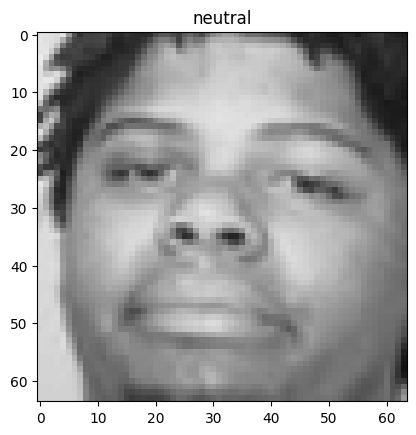

In [13]:
class_names = trainset.classes

index = random.randint(0, len(trainset)-1)
image, label = trainset[index]

image = unnormalize(image, FER_MEAN, FER_STD)
plt.imshow(image.permute(1, 2, 0)) # (h, w, c)
plt.title(class_names[label])

Text(0.5, 1.0, 'happy')

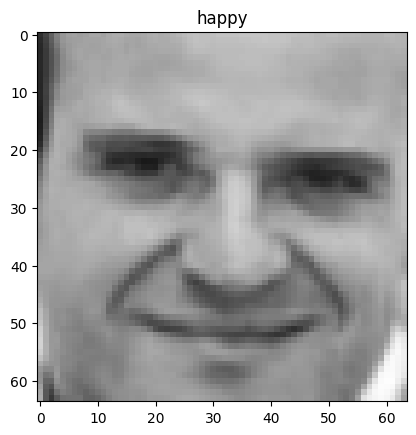

In [14]:
class_names = validset.classes

index = random.randint(0, len(validset)-1)
image, label = validset[index]

image = unnormalize(image, FER_MEAN, FER_STD)
plt.imshow(image.permute(1, 2, 0)) # (h, w, c)
plt.title(class_names[label])

## Load Dataset into Batches

In [15]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch.nn as nn

In [16]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)
for _, labels in trainloader:
    print("Trainloader check → label min/max:", labels.min().item(), labels.max().item())
    break

Trainloader check → label min/max: 0 6


In [17]:
print(f"Total no. of batches in trainloader : {len(trainloader)}")
print(f"Total no. of batches in validloader : {len(validloader)}")

Total no. of batches in trainloader : 898
Total no. of batches in validloader : 225


In [18]:
for images, labels in trainloader:
    break;

print(f"One image batch shape : {images.shape}")
print(f"One label batch shape : {labels.shape}")

One image batch shape : torch.Size([32, 3, 64, 64])
One label batch shape : torch.Size([32])


In [19]:
allowed_classes = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise']

trainset = ImageFolder(TRAIN_IMG_FOLDER_PATH, transform=train_aug)
validset = ImageFolder(VALID_IMG_FOLDER_PATH, transform=valid_aug)

def filter_dataset(dataset, allowed_classes):
    original_class_to_idx = dataset.class_to_idx
    idx_to_class = {v: k for k, v in original_class_to_idx.items()}

    filtered_samples = [
        (path, idx_to_class[label])
        for path, label in dataset.samples
        if idx_to_class[label] in allowed_classes
    ]

    new_class_to_idx = {cls: i for i, cls in enumerate(allowed_classes)}
    remapped_samples = [
        (path, new_class_to_idx[class_name])
        for path, class_name in filtered_samples
    ]

    dataset.samples = remapped_samples
    dataset.targets = [label for _, label in remapped_samples]
    dataset.classes = allowed_classes
    dataset.class_to_idx = new_class_to_idx

    return dataset

trainset = filter_dataset(trainset, allowed_classes)
validset = filter_dataset(validset, allowed_classes)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(allowed_classes)),
    y=trainset.targets
)

weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(DEVICE)
loss_fn = nn.CrossEntropyLoss(weight=weights_tensor)


class_names = trainset.classes

trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

for _, labels_check in trainloader:
    print("Trainloader check → Label min/max:", labels_check.min().item(), labels_check.max().item())
    break

print("Trainset label min/max:", min(trainset.targets), max(trainset.targets))
print("Validset label min/max:", min(validset.targets), max(validset.targets))

Trainloader check → Label min/max: 0 5
Trainset label min/max: 0 5
Validset label min/max: 0 5


## Create Model

In [20]:
import timm
from torch import nn
import torch.nn.functional as F

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction),
            nn.ReLU(),
            nn.Linear(channels // reduction, channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y

class ResidualSEBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.se = SEBlock(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = self.se(out)
        out += self.shortcut(x)
        return F.relu(out)

class ImprovedCNN(nn.Module):
    def __init__(self, num_classes=7):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            ResidualSEBlock(64, 128, stride=2),   # 48 → 24
            ResidualSEBlock(128, 256, stride=2),  # 24 → 12
            ResidualSEBlock(256, 512, stride=2),  # 12 → 6
            ResidualSEBlock(512, 512, stride=2),  # 6 → 3

            nn.AdaptiveAvgPool2d((1, 1))
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

In [22]:
model = ImprovedCNN(num_classes=6).to(DEVICE)

In [23]:
# https://saturncloud.io/blog/check-the-total-number-of-parameters-in-a-pytorch-model/
model_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {model_params}")

Number of parameters: 10018078


# Create Train and Eval Function

In [24]:
from tqdm import tqdm

In [25]:
def multiclass_accuracy(y_pred, y_true):
    preds = torch.argmax(y_pred, dim=1)
    correct = (preds == y_true).float()
    return correct.sum() / len(y_true)

In [26]:
def train_fn(model, dataloader, optimizer, current_epo):
    model.train()
    total_loss = 0.0
    total_acc = 0.0
    losses_list = []
    accuracy_list = []
    tk = tqdm(dataloader, desc = "EPOCH" + "[TRAIN]" + str(current_epo + 1) + "/" + str(EPOCHS))

    for t, data in enumerate(tk):
        images, labels = data
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        logits = model(images)
        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        losses_list.append(loss.item())
        total_acc += multiclass_accuracy(logits, labels)
        accuracy_list.append(multiclass_accuracy(logits, labels).item())
        tk.set_postfix({'loss' : '%6f' %float(total_loss / (t+1)), 'acc' : '%6f' %float(total_acc / (t+1)),})

    return total_loss / len(dataloader), total_acc / len(dataloader), losses_list, accuracy_list

In [27]:
def eval_fn(model, dataloader, current_epo):
    model.eval()
    total_loss = 0.0
    total_acc = 0.0
    losses_list_val = []
    accuracy_list_val = []
    tk = tqdm(dataloader, desc = "EPOCH" + "[EVAL]" + str(current_epo + 1) + "/" + str(EPOCHS))

    for t, data in enumerate(tk):
        images, labels = data
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        logits = model(images)
        loss = loss_fn(logits, labels)


        total_loss += loss.item()
        losses_list_val.append(loss.item())

        total_acc += multiclass_accuracy(logits, labels)
        accuracy_list_val.append(multiclass_accuracy(logits, labels).item())

        tk.set_postfix({'loss' : '%6f' %float(total_loss / (t+1)), 'acc' : '%6f' %float(total_acc / (t+1)),})

    return total_loss / len(dataloader), total_acc / len(dataloader), losses_list_val, accuracy_list_val

# Create Training Loop

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.optim import lr_scheduler

# https://www.datacamp.com/tutorial/adamw-optimizer-in-pytorch
optimizer = torch.optim.AdamW(params=model.parameters(), lr=LR, weight_decay=0.01)

# https://docs.pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [29]:
patience = 25
counter = 0
min_lr = 1e-6
best_valid_loss = np.inf
losses_accum = []
accuracy_accum = []
losses_accum_val = []
accuracy_accum_val = []


for i in range(EPOCHS):
    train_loss, train_acc, losses_list, accuracy_list = train_fn(model, trainloader, optimizer, i)
    valid_loss, valid_acc, losses_list_val, accuracy_list_val = eval_fn(model, validloader, i)

    losses_accum += losses_list
    losses_accum_val += losses_list_val
    accuracy_accum += accuracy_list
    accuracy_accum_val += accuracy_list_val

    if valid_loss < best_valid_loss - 1e-4:
        torch.save(model.state_dict(), 'best-weights.pt')
        print("SAVED-BEST-WEIGHTS")
        best_valid_loss = valid_loss
        counter = 0
    else:
        counter += 1
        print(f"No improvement in validation loss. Patience counter: {counter}/{patience}")

    scheduler.step(valid_loss)

    current_lr = optimizer.param_groups[0]['lr']
    if counter >= patience:
        print("Early stopping: No improvement after", patience, "epochs.")
        break
    if current_lr < min_lr:
        print(f"Learning rate too low ({current_lr:.2e}). Stopping training.")
        break

EPOCH[EVAL]1/200: 100%|██████████| 186/186 [00:28<00:00,  6.46it/s, loss=1.773110, acc=0.237023]


SAVED-BEST-WEIGHTS


EPOCH[EVAL]2/200: 100%|██████████| 186/186 [00:08<00:00, 21.36it/s, loss=1.668445, acc=0.332789]


SAVED-BEST-WEIGHTS


EPOCH[EVAL]3/200: 100%|██████████| 186/186 [00:08<00:00, 20.96it/s, loss=1.598998, acc=0.376230]


SAVED-BEST-WEIGHTS


EPOCH[EVAL]4/200: 100%|██████████| 186/186 [00:08<00:00, 21.97it/s, loss=1.635208, acc=0.349583]


No improvement in validation loss. Patience counter: 1/25


EPOCH[EVAL]5/200: 100%|██████████| 186/186 [00:08<00:00, 21.33it/s, loss=1.403236, acc=0.445712]


SAVED-BEST-WEIGHTS


EPOCH[EVAL]6/200: 100%|██████████| 186/186 [00:08<00:00, 21.04it/s, loss=1.283241, acc=0.490766]


SAVED-BEST-WEIGHTS


EPOCH[EVAL]7/200: 100%|██████████| 186/186 [00:08<00:00, 21.61it/s, loss=1.290357, acc=0.474059]


No improvement in validation loss. Patience counter: 1/25


EPOCH[EVAL]8/200: 100%|██████████| 186/186 [00:08<00:00, 22.94it/s, loss=1.197954, acc=0.526358]


SAVED-BEST-WEIGHTS


EPOCH[EVAL]9/200: 100%|██████████| 186/186 [00:08<00:00, 21.37it/s, loss=1.254624, acc=0.486566]


No improvement in validation loss. Patience counter: 1/25


EPOCH[EVAL]10/200: 100%|██████████| 186/186 [00:08<00:00, 21.08it/s, loss=1.160391, acc=0.523239]


SAVED-BEST-WEIGHTS


EPOCH[EVAL]11/200: 100%|██████████| 186/186 [00:10<00:00, 18.22it/s, loss=1.145609, acc=0.529429]


SAVED-BEST-WEIGHTS


EPOCH[EVAL]12/200: 100%|██████████| 186/186 [00:08<00:00, 20.75it/s, loss=1.128495, acc=0.541983]


SAVED-BEST-WEIGHTS


EPOCH[EVAL]13/200: 100%|██████████| 186/186 [00:08<00:00, 21.29it/s, loss=1.117043, acc=0.555759]


SAVED-BEST-WEIGHTS


EPOCH[EVAL]14/200: 100%|██████████| 186/186 [00:08<00:00, 20.87it/s, loss=1.062077, acc=0.568192]


SAVED-BEST-WEIGHTS


EPOCH[EVAL]15/200: 100%|██████████| 186/186 [00:08<00:00, 21.16it/s, loss=1.061635, acc=0.571888]


SAVED-BEST-WEIGHTS


EPOCH[EVAL]16/200: 100%|██████████| 186/186 [00:08<00:00, 20.79it/s, loss=1.036117, acc=0.583340]


SAVED-BEST-WEIGHTS


EPOCH[EVAL]17/200: 100%|██████████| 186/186 [00:08<00:00, 21.18it/s, loss=1.009460, acc=0.598098]


SAVED-BEST-WEIGHTS


EPOCH[EVAL]18/200: 100%|██████████| 186/186 [00:08<00:00, 21.23it/s, loss=1.015558, acc=0.595605]


No improvement in validation loss. Patience counter: 1/25


EPOCH[EVAL]19/200: 100%|██████████| 186/186 [00:08<00:00, 20.93it/s, loss=1.023455, acc=0.596539]


No improvement in validation loss. Patience counter: 2/25


EPOCH[EVAL]20/200: 100%|██████████| 186/186 [00:09<00:00, 20.36it/s, loss=0.999982, acc=0.607218]


SAVED-BEST-WEIGHTS


EPOCH[EVAL]21/200: 100%|██████████| 186/186 [00:08<00:00, 22.16it/s, loss=0.968865, acc=0.623421]


SAVED-BEST-WEIGHTS


EPOCH[EVAL]22/200: 100%|██████████| 186/186 [00:08<00:00, 21.23it/s, loss=0.955869, acc=0.631915]


SAVED-BEST-WEIGHTS


EPOCH[EVAL]23/200: 100%|██████████| 186/186 [00:08<00:00, 21.45it/s, loss=0.963680, acc=0.626855]


No improvement in validation loss. Patience counter: 1/25


EPOCH[EVAL]24/200: 100%|██████████| 186/186 [00:09<00:00, 20.46it/s, loss=0.949570, acc=0.627715]


SAVED-BEST-WEIGHTS


EPOCH[EVAL]25/200: 100%|██████████| 186/186 [00:08<00:00, 21.46it/s, loss=0.912828, acc=0.650901]


SAVED-BEST-WEIGHTS


EPOCH[EVAL]26/200: 100%|██████████| 186/186 [00:08<00:00, 21.13it/s, loss=0.908889, acc=0.644301]


SAVED-BEST-WEIGHTS


EPOCH[EVAL]27/200: 100%|██████████| 186/186 [00:08<00:00, 21.42it/s, loss=0.919851, acc=0.649220]


No improvement in validation loss. Patience counter: 1/25


EPOCH[EVAL]28/200: 100%|██████████| 186/186 [00:08<00:00, 22.48it/s, loss=0.916983, acc=0.656230]


No improvement in validation loss. Patience counter: 2/25


EPOCH[EVAL]29/200: 100%|██████████| 186/186 [00:08<00:00, 21.74it/s, loss=0.907886, acc=0.646915]


SAVED-BEST-WEIGHTS


EPOCH[EVAL]30/200: 100%|██████████| 186/186 [00:08<00:00, 21.31it/s, loss=0.896747, acc=0.651405]


SAVED-BEST-WEIGHTS


EPOCH[EVAL]31/200: 100%|██████████| 186/186 [00:08<00:00, 21.51it/s, loss=0.894136, acc=0.657957]


SAVED-BEST-WEIGHTS


EPOCH[EVAL]32/200: 100%|██████████| 186/186 [00:08<00:00, 21.92it/s, loss=0.918276, acc=0.648259]


No improvement in validation loss. Patience counter: 1/25


EPOCH[EVAL]33/200: 100%|██████████| 186/186 [00:08<00:00, 21.39it/s, loss=0.905002, acc=0.655726]


No improvement in validation loss. Patience counter: 2/25


EPOCH[EVAL]34/200: 100%|██████████| 186/186 [00:08<00:00, 21.20it/s, loss=0.866005, acc=0.665854]


SAVED-BEST-WEIGHTS


EPOCH[EVAL]35/200: 100%|██████████| 186/186 [00:08<00:00, 21.56it/s, loss=0.891092, acc=0.653851]


No improvement in validation loss. Patience counter: 1/25


EPOCH[EVAL]36/200: 100%|██████████| 186/186 [00:08<00:00, 22.96it/s, loss=0.904425, acc=0.652292]


No improvement in validation loss. Patience counter: 2/25


EPOCH[EVAL]37/200: 100%|██████████| 186/186 [00:08<00:00, 21.80it/s, loss=0.872984, acc=0.668810]


No improvement in validation loss. Patience counter: 3/25


EPOCH[EVAL]38/200: 100%|██████████| 186/186 [00:08<00:00, 22.39it/s, loss=0.857927, acc=0.670605]


SAVED-BEST-WEIGHTS


EPOCH[EVAL]39/200: 100%|██████████| 186/186 [00:08<00:00, 21.20it/s, loss=0.854252, acc=0.674805]


SAVED-BEST-WEIGHTS


EPOCH[EVAL]40/200: 100%|██████████| 186/186 [00:08<00:00, 21.74it/s, loss=0.879551, acc=0.665255]


No improvement in validation loss. Patience counter: 1/25


EPOCH[EVAL]41/200: 100%|██████████| 186/186 [00:09<00:00, 19.79it/s, loss=0.850116, acc=0.673004]


SAVED-BEST-WEIGHTS


EPOCH[EVAL]42/200: 100%|██████████| 186/186 [00:08<00:00, 21.55it/s, loss=0.820562, acc=0.688199]


SAVED-BEST-WEIGHTS


EPOCH[EVAL]43/200: 100%|██████████| 186/186 [00:08<00:00, 22.45it/s, loss=0.884705, acc=0.673629]


No improvement in validation loss. Patience counter: 1/25


EPOCH[EVAL]44/200: 100%|██████████| 186/186 [00:08<00:00, 22.26it/s, loss=0.885960, acc=0.673629]


No improvement in validation loss. Patience counter: 2/25


EPOCH[EVAL]45/200: 100%|██████████| 186/186 [00:08<00:00, 21.87it/s, loss=0.824412, acc=0.687527]


No improvement in validation loss. Patience counter: 3/25


EPOCH[EVAL]46/200: 100%|██████████| 186/186 [00:08<00:00, 21.50it/s, loss=0.825934, acc=0.691895]


No improvement in validation loss. Patience counter: 4/25


EPOCH[EVAL]47/200: 100%|██████████| 186/186 [00:08<00:00, 21.12it/s, loss=0.826040, acc=0.702023]


No improvement in validation loss. Patience counter: 5/25


EPOCH[EVAL]48/200: 100%|██████████| 186/186 [00:08<00:00, 22.16it/s, loss=0.838906, acc=0.692110]


No improvement in validation loss. Patience counter: 6/25


EPOCH[EVAL]49/200: 100%|██████████| 186/186 [00:08<00:00, 21.77it/s, loss=0.801740, acc=0.701015]


SAVED-BEST-WEIGHTS


EPOCH[EVAL]50/200: 100%|██████████| 186/186 [00:08<00:00, 20.75it/s, loss=0.819252, acc=0.700007]


No improvement in validation loss. Patience counter: 1/25


EPOCH[EVAL]51/200: 100%|██████████| 186/186 [00:10<00:00, 18.10it/s, loss=0.803317, acc=0.704617]


No improvement in validation loss. Patience counter: 2/25


EPOCH[EVAL]52/200: 100%|██████████| 186/186 [00:08<00:00, 21.02it/s, loss=0.816547, acc=0.706223]


No improvement in validation loss. Patience counter: 3/25


EPOCH[EVAL]53/200: 100%|██████████| 186/186 [00:09<00:00, 20.66it/s, loss=0.807317, acc=0.716640]


No improvement in validation loss. Patience counter: 4/25


EPOCH[EVAL]54/200: 100%|██████████| 186/186 [00:09<00:00, 20.10it/s, loss=0.801661, acc=0.717816]


No improvement in validation loss. Patience counter: 5/25


EPOCH[EVAL]55/200: 100%|██████████| 186/186 [00:09<00:00, 20.60it/s, loss=0.814397, acc=0.718320]


No improvement in validation loss. Patience counter: 6/25


EPOCH[EVAL]56/200: 100%|██████████| 186/186 [00:08<00:00, 21.15it/s, loss=0.817460, acc=0.713448]


No improvement in validation loss. Patience counter: 7/25


EPOCH[EVAL]57/200: 100%|██████████| 186/186 [00:09<00:00, 20.59it/s, loss=0.807501, acc=0.719328]


No improvement in validation loss. Patience counter: 8/25


EPOCH[EVAL]58/200: 100%|██████████| 186/186 [00:08<00:00, 21.10it/s, loss=0.824168, acc=0.720168]


No improvement in validation loss. Patience counter: 9/25


EPOCH[EVAL]59/200: 100%|██████████| 186/186 [00:08<00:00, 22.03it/s, loss=0.820162, acc=0.722856]


No improvement in validation loss. Patience counter: 10/25


EPOCH[EVAL]60/200: 100%|██████████| 186/186 [00:08<00:00, 21.89it/s, loss=0.829604, acc=0.721512]


No improvement in validation loss. Patience counter: 11/25


EPOCH[EVAL]61/200: 100%|██████████| 186/186 [00:08<00:00, 21.21it/s, loss=0.814410, acc=0.722856]


No improvement in validation loss. Patience counter: 12/25


EPOCH[EVAL]62/200: 100%|██████████| 186/186 [00:08<00:00, 21.23it/s, loss=0.830505, acc=0.722688]


No improvement in validation loss. Patience counter: 13/25


EPOCH[EVAL]63/200: 100%|██████████| 186/186 [00:08<00:00, 20.74it/s, loss=0.826768, acc=0.722352]


No improvement in validation loss. Patience counter: 14/25


EPOCH[EVAL]64/200: 100%|██████████| 186/186 [00:08<00:00, 20.96it/s, loss=0.825058, acc=0.724200]


No improvement in validation loss. Patience counter: 15/25


EPOCH[EVAL]65/200: 100%|██████████| 186/186 [00:08<00:00, 20.74it/s, loss=0.827907, acc=0.723528]


No improvement in validation loss. Patience counter: 16/25


EPOCH[EVAL]66/200: 100%|██████████| 186/186 [00:08<00:00, 21.56it/s, loss=0.832656, acc=0.722688]


No improvement in validation loss. Patience counter: 17/25


EPOCH[EVAL]67/200: 100%|██████████| 186/186 [00:09<00:00, 18.72it/s, loss=0.836977, acc=0.723360]


No improvement in validation loss. Patience counter: 18/25


EPOCH[EVAL]68/200: 100%|██████████| 186/186 [00:10<00:00, 17.27it/s, loss=0.840914, acc=0.724704]


No improvement in validation loss. Patience counter: 19/25


EPOCH[EVAL]69/200: 100%|██████████| 186/186 [00:11<00:00, 16.74it/s, loss=0.842114, acc=0.723360]


No improvement in validation loss. Patience counter: 20/25


EPOCH[EVAL]70/200: 100%|██████████| 186/186 [00:08<00:00, 21.56it/s, loss=0.840983, acc=0.722688]


No improvement in validation loss. Patience counter: 21/25


EPOCH[EVAL]71/200: 100%|██████████| 186/186 [00:08<00:00, 21.17it/s, loss=0.845518, acc=0.724536]


No improvement in validation loss. Patience counter: 22/25


EPOCH[EVAL]72/200: 100%|██████████| 186/186 [00:08<00:00, 20.68it/s, loss=0.838974, acc=0.723360]


No improvement in validation loss. Patience counter: 23/25


EPOCH[EVAL]73/200: 100%|██████████| 186/186 [00:08<00:00, 21.74it/s, loss=0.828103, acc=0.726216]


No improvement in validation loss. Patience counter: 24/25


EPOCH[EVAL]74/200: 100%|██████████| 186/186 [00:08<00:00, 21.46it/s, loss=0.844355, acc=0.722688]

No improvement in validation loss. Patience counter: 25/25
Early stopping: No improvement after 25 epochs.


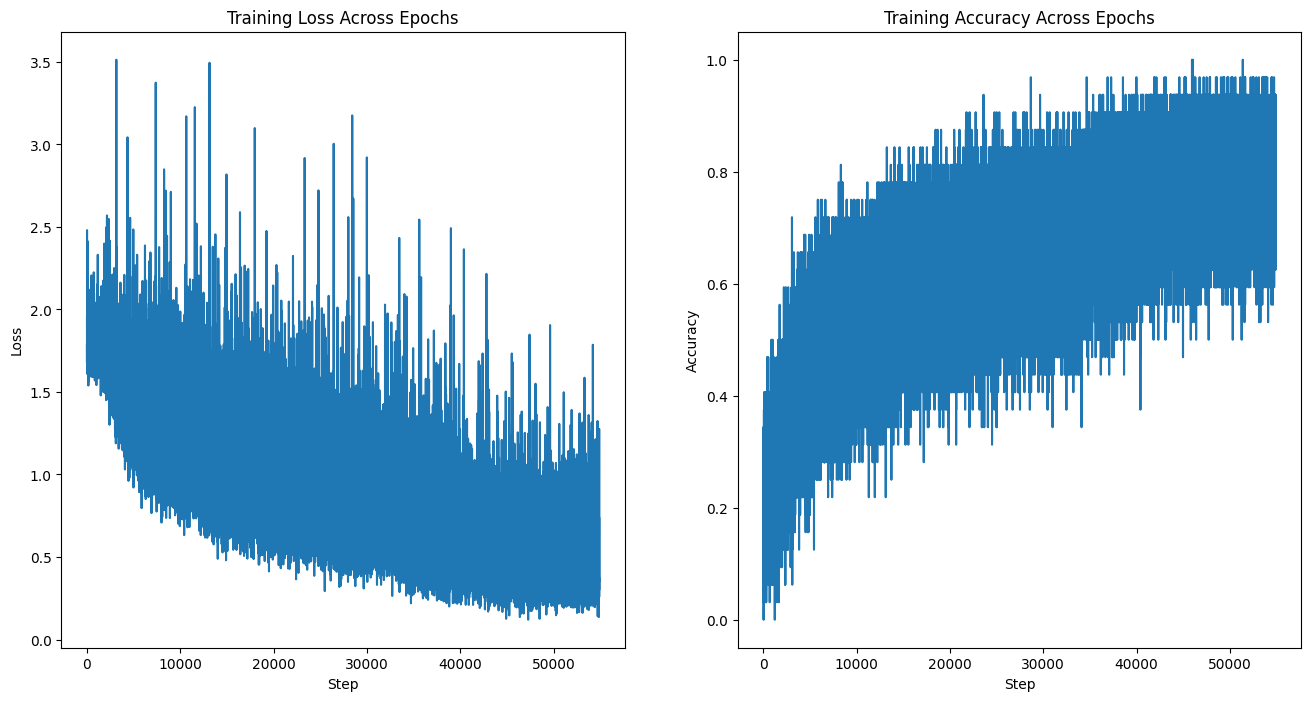

In [30]:
fig, axs = plt.subplots(1,2, figsize=(16,8))

axs[0].plot(losses_accum)
axs[0].set_xlabel('Step')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training Loss Across Epochs')

axs[1].plot(accuracy_accum)
axs[1].set_xlabel('Step')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Training Accuracy Across Epochs')
plt.show()

# Evaluation

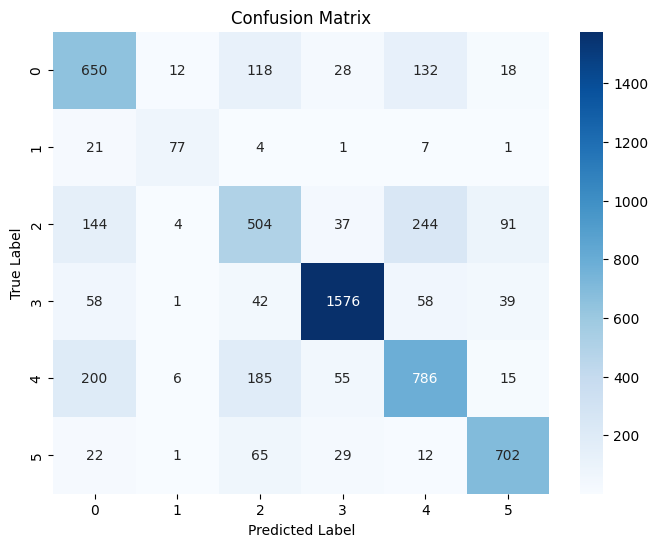

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


all_preds = []
all_labels = []

model.eval()

with torch.no_grad():
    for images, labels in validloader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


conf_matrix = confusion_matrix(all_labels, all_preds)


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

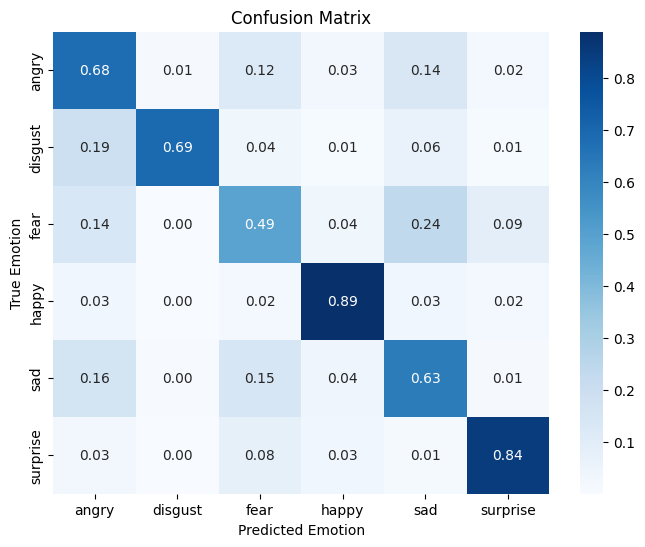

In [32]:
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(8, 6))
conf_matrix = confusion_matrix(all_labels, all_preds, labels=range(len(class_names)), normalize='true')
sns.heatmap(conf_matrix, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Emotion')
plt.ylabel('True Emotion')
plt.title('Confusion Matrix')
plt.show()

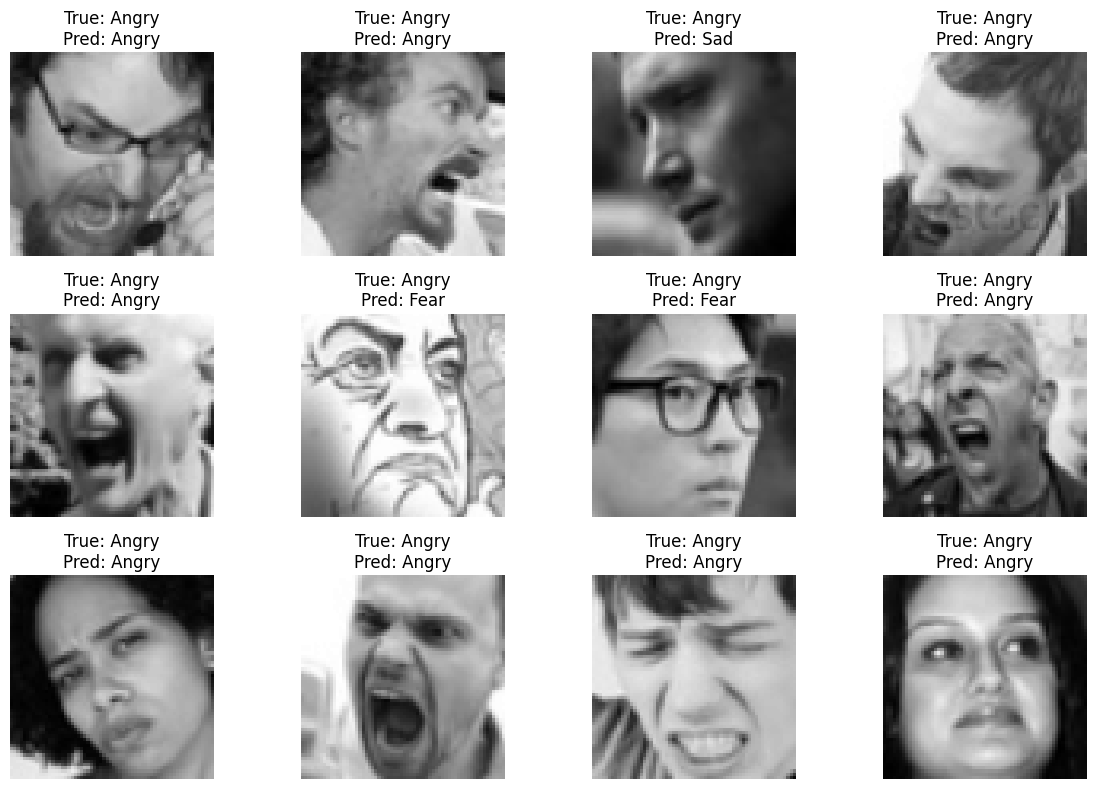

In [33]:
classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise']
n_images = 12

collected_images = []
collected_labels = []
collected_preds = []

model.eval()

for images, labels in validloader:
    images = images.to(DEVICE).requires_grad_()
    outputs = model(images)
    preds = torch.argmax(outputs, 1)

    for i in range(len(images)):
        img = images[i].detach().cpu()
        unnorm_img = unnormalize(img, FER_MEAN, FER_STD)
        unnorm_img = torch.clamp(unnorm_img, 0.0, 1.0)

        collected_images.append(unnorm_img)
        collected_labels.append(labels[i])
        collected_preds.append(preds[i].cpu())

        if len(collected_images) >= n_images:
            break
    if len(collected_images) >= n_images:
        break

fig, axes = plt.subplots(3, 4, figsize=(12, 8))
axes = axes.flatten()

for i in range(n_images):
    img_tensor = collected_images[i]

    if img_tensor.shape[0] == 1:
        img = img_tensor.squeeze(0).numpy()
        axes[i].imshow(img, cmap='gray')
    else:
        img = img_tensor.permute(1, 2, 0).numpy()
        axes[i].imshow(img)

    true_label = collected_labels[i]
    pred_label = collected_preds[i]
    axes[i].set_title(f"True: {classes[true_label]}\nPred: {classes[pred_label]}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()

In [77]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

print(classification_report(all_labels, all_preds, target_names=allowed_classes))

Precision: 0.7105
Recall: 0.7046
F1-score: 0.7065
              precision    recall  f1-score   support

       angry       0.59      0.68      0.63       958
     disgust       0.76      0.69      0.73       111
        fear       0.55      0.49      0.52      1024
       happy       0.91      0.89      0.90      1774
         sad       0.63      0.63      0.63      1247
    surprise       0.81      0.84      0.83       831

    accuracy                           0.72      5945
   macro avg       0.71      0.70      0.71      5945
weighted avg       0.72      0.72      0.72      5945



# gradCAM

In [120]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ImprovedCNN(num_classes=6).to(DEVICE)
model.load_state_dict(torch.load("best-weights.pt", map_location=DEVICE))

<All keys matched successfully>

In [121]:
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer

        self.gradients = None
        self.activations = None

        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, input_tensor, target_class=None):
        self.model.eval()
        self.model.zero_grad()

        output = self.model(input_tensor)

        if target_class is None:
            target_class = output.argmax(dim=1).item()

        class_loss = output[0, target_class]
        class_loss.backward()

        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        gradcam_map = F.relu(torch.sum(weights * self.activations, dim=1)).squeeze()

        gradcam_map -= gradcam_map.min()
        gradcam_map /= gradcam_map.max() + 1e-8

        return gradcam_map.cpu().numpy(), target_class

def show_gradcam_on_image(img, mask, alpha=0.5):
    assert len(img.shape) == 3 and img.shape[0] in [1, 3]
    assert mask.ndim == 2

    img = img.permute(1, 2, 0).cpu().numpy()
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)
    if img.shape[2] == 1:
        img = np.repeat(img, 3, axis=2)

    mask_resized = cv2.resize(mask, (img.shape[1], img.shape[0]))
    mask_resized = (mask_resized - mask_resized.min()) / (mask_resized.max() - mask_resized.min() + 1e-8)

    mask_resized = 1 - mask_resized

    heatmap = cv2.applyColorMap(np.uint8(255 * mask_resized), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255.0

    overlay = heatmap * alpha + img * (1 - alpha)
    overlay = np.clip(overlay, 0, 1)

    return overlay

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


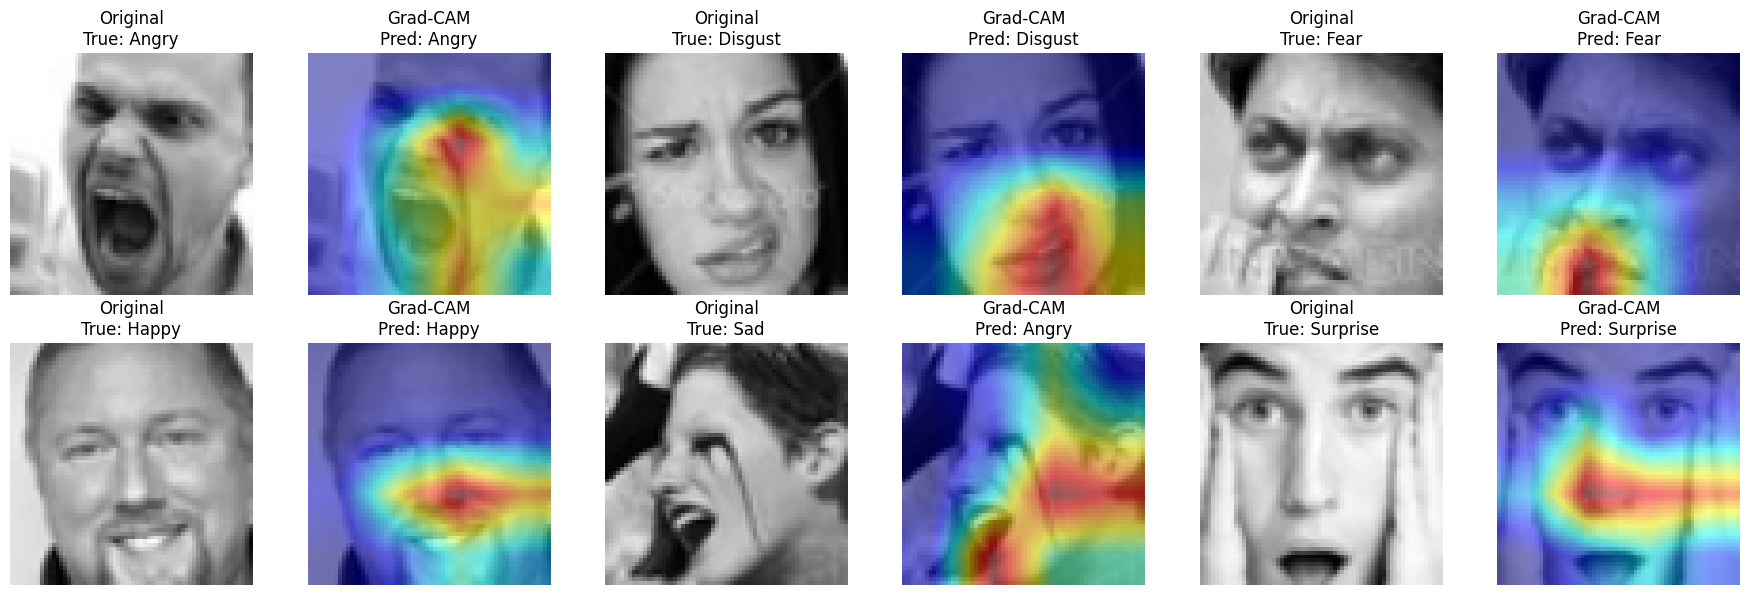

In [122]:
classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise']
indices = [9, 988, 1200, 3000, 5000, 5500]

fig, axes = plt.subplots(2, 6, figsize=(18, 6))
axes = axes.flatten()

model.eval()

for i, idx in enumerate(indices):
    image, label = validset[idx]
    input_tensor = image.unsqueeze(0).to(DEVICE)
    input_tensor.requires_grad_()

    target_layer = model.features[6]
    gradcam = GradCAM(model, target_layer)

    mask, pred_class = gradcam.generate(input_tensor)
    heatmap_img = show_gradcam_on_image(image.cpu(), mask)

    original_img = image.permute(1, 2, 0).numpy()
    original_img = (original_img - original_img.min()) / (original_img.max() - original_img.min() + 1e-8)

    axes[2*i].imshow(original_img)
    axes[2*i].set_title(f"Original\nTrue: {classes[label]}")
    axes[2*i].axis("off")

    axes[2*i+1].imshow(heatmap_img)
    axes[2*i+1].set_title(f"Grad-CAM\nPred: {classes[pred_class]}")
    axes[2*i+1].axis("off")

plt.tight_layout()
plt.show()

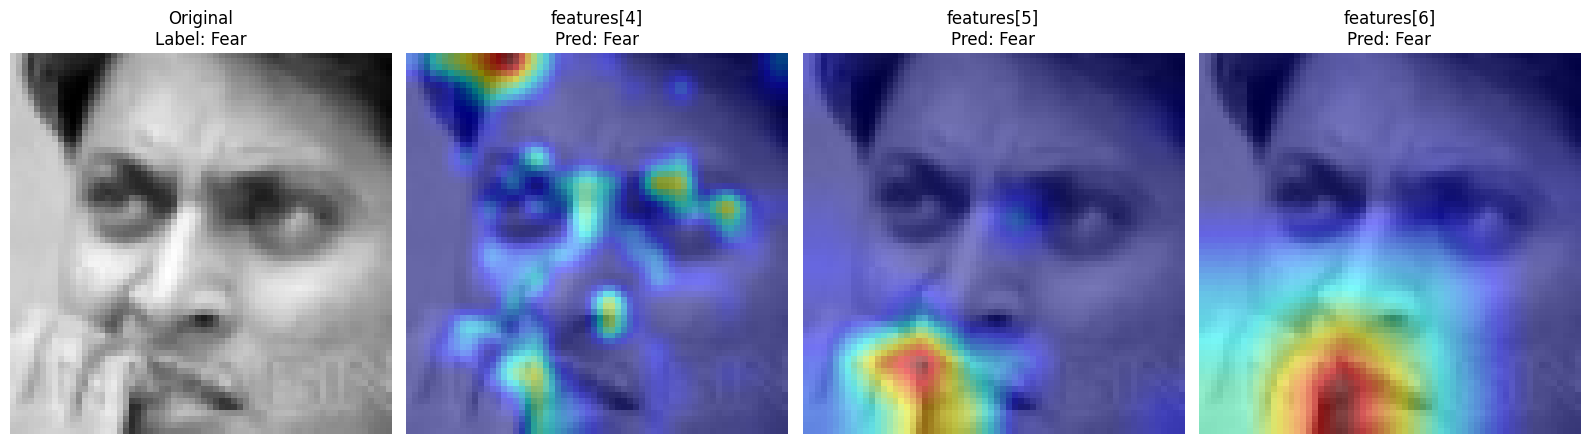

In [123]:
import torch
import matplotlib.pyplot as plt

classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise']
idx = 1200
image, label = validset[idx]
input_tensor = image.unsqueeze(0).to(DEVICE)
input_tensor.requires_grad_()

layers_to_test = {
    "features[4]": model.features[4],
    "features[5]": model.features[5],
    "features[6]": model.features[6],
}

fig, axes = plt.subplots(1, len(layers_to_test) + 1, figsize=(16, 5))
model.eval()

original_img = image.permute(1, 2, 0).numpy()
original_img = (original_img - original_img.min()) / (original_img.max() - original_img.min() + 1e-8)
axes[0].imshow(original_img)
axes[0].set_title(f"Original\nLabel: {classes[label]}")
axes[0].axis("off")

for i, (layer_name, layer) in enumerate(layers_to_test.items(), start=1):
    gradcam = GradCAM(model, target_layer=layer)
    mask, pred_class = gradcam.generate(input_tensor)
    heatmap_img = show_gradcam_on_image(image.cpu(), mask)

    axes[i].imshow(heatmap_img)
    axes[i].set_title(f"{layer_name}\nPred: {classes[pred_class]}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()

# GradCAM from torchcam

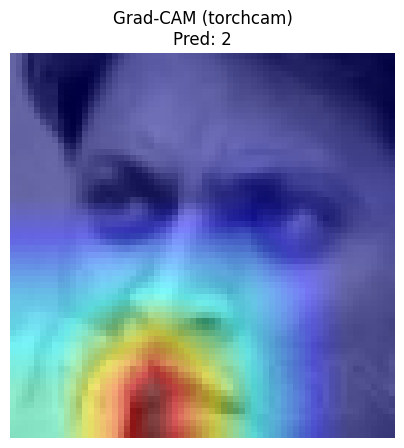

In [125]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
from torchcam.methods import GradCAM
from PIL import Image
import cv2

model = ImprovedCNN(num_classes=6)
model.load_state_dict(torch.load("best-weights.pt", map_location="cpu"))
model.eval()

cam_extractor = GradCAM(model, target_layer="features.6")

image, label = validset[1200]
input_tensor = image.unsqueeze(0)

output = model(input_tensor)
pred_class = output.argmax(dim=1).item()
activation_map = cam_extractor(pred_class, output)[0].squeeze().cpu().numpy()

img_np = image.permute(1, 2, 0).numpy()
img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min() + 1e-8)
img_uint8 = (img_np * 255).astype(np.uint8)

heatmap_resized = cv2.resize(activation_map, (img_uint8.shape[1], img_uint8.shape[0]))
heatmap_resized = np.clip(heatmap_resized, 0, None)
heatmap_resized = heatmap_resized / (heatmap_resized.max() + 1e-8)

heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)

overlay = 0.5 * heatmap_color / 255.0 + 0.5 * img_uint8 / 255.0
overlay = np.clip(overlay, 0, 1)

plt.figure(figsize=(5, 5))
plt.imshow(overlay)
plt.title(f"Grad-CAM (torchcam)\nPred: {pred_class}")
plt.axis("off")
plt.show()

# Inference

In [116]:
def view_classify(img, ps):

    classes = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise']

    ps = ps.data.cpu().numpy().squeeze()
    img = img.numpy().transpose(1,2,0)

    fig, (ax1, ax2) = plt.subplots(figsize = (5,9), ncols = 2)
    ax1.imshow(img)
    ax1.axis('off')
    ax2.barh(classes, ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(classes)
    ax2.set_yticklabels(classes)
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

    return None

Gold label: angry


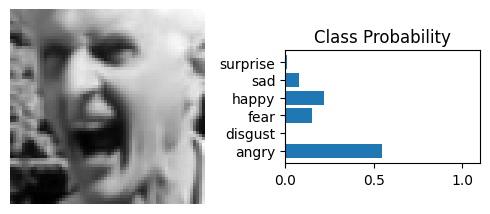

In [117]:
image, label = validset[4]
image = image.unsqueeze(0)
image = unnormalize(image, FER_MEAN, FER_STD)

logits = model(image.to(DEVICE))
probs = nn.Softmax(dim=1)(logits)

view_classify(image.squeeze(), probs)

print(f"Gold label: {class_names[label]}")

In [119]:
model = ImprovedCNN(num_classes=6)
model.load_state_dict(torch.load("best-weights.pt"))
model.to(DEVICE)
model.eval()

correct = 0
total = 0
total_loss = 0.0

with torch.no_grad():
    for images, labels in validloader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)

        loss = loss_fn(outputs, labels)
        total_loss += loss.item() * labels.size(0)  # sum loss over batch

        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total * 100
avg_loss = total_loss / total

print(f"Final validation accuracy: {accuracy:.2f}%")
print(f"Final validation loss: {avg_loss:.4f}")

Final validation accuracy: 70.08%
Final validation loss: 0.8023
